# Annotating certificate references with LLMs
## Before you launch
1. Create a file `openai_api_key` in the root directory and paste your key there.
2. Make sure you have the CC dataset extracted into project `cc_data` in the project root directory.
## What is being done here
1. Obtain names, certificate IDs, digests, and old digests from the CCDataset.
2. Create an annotations dataframe based on the annotations in `src/sec_certs/data/reference_annotations/final/train.csv`.
3. Enrich the annotations dataframe with the raw texts in `cc_data/certs/reports/txt`.
4. Enrich the annotations dataframe with the old digests (the annotation dataframe uses old ones), target cert IDs, names and target names.
5. Call the OpenAI API with structured outputs to label the certificate reference based on instructions in `notebooks/llm_annotation_prompt.txt`
6. Analyze the metrics with a confusion matrix.

In [2]:
from sec_certs.dataset.cc import CCDataset
from sec_certs.sample import CCCertificate
import pandas as pd
import csv
import os

In [16]:
if "dgst_map.csv" not in os.listdir():
    # get dgst mappings
    if os.path.exists("../../cc_data/dataset.json"):
        dset = CCDataset.from_json("../../cc_data/dataset.json")
    else:
        dset = CCDataset.from_web()
    data = [(row.name, row.heuristics.cert_id, row.dgst, row.old_dgst) for row in dset]
    with open('dgst_map.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['name', 'cert_id', 'dgst', 'old_dgst'])  # Header
        writer.writerows(data)
dgst_map_df = pd.read_csv("dgst_map.csv")

Method auxiliary_datasets_dir can only be called on backed dataset.
Method auxiliary_datasets_dir can only be called on backed dataset.
Method auxiliary_datasets_dir can only be called on backed dataset.
Method auxiliary_datasets_dir can only be called on backed dataset.
Method auxiliary_datasets_dir can only be called on backed dataset.
Method auxiliary_datasets_dir can only be called on backed dataset.


In [18]:
if not 'dset' in vars() and not 'dset' in globals():
    dset = CCDataset.from_json("../../cc_data/dataset.json")

In [19]:
from sec_certs.model.references_nlp.segment_extractor import ReferenceSegmentExtractor

In [20]:
reports_path = '../../cc_data/certs/reports/txt'
if not os.path.exists(reports_path):
    raise FileNotFoundError(f"The reports directory {os.path.abspath(reports_path)} does not exist, make sure you have the CC dataset unpacked.")

reports_files = os.listdir(reports_path)
# print(reports_files)
def add_text_content(dgst: str):
    if f"{dgst}.txt" not in reports_files:
        return ""
    return open(reports_path + "/" + dgst + ".txt").read()

In [35]:
df_annotations = pd.read_csv("../../src/sec_certs/data/reference_annotations/final/train.csv") \
    .rename(columns={"dgst": "old_dgst", "canonical_reference_keyword": "target_cert_id"}) \
    .merge(dgst_map_df, on="old_dgst") \
    .merge(dgst_map_df[["name", "cert_id"]].rename(columns={"name": "target_name", "cert_id": "target_cert_id"}), on="target_cert_id")

## get fulltext
df_annotations["text_content"] = df_annotations["dgst"] \
    .apply(add_text_content)

## get segments
if "ref_segments.parquet" not in os.listdir():
    used_certs = []
    for cert in dset:
        if cert.dgst in df_annotations["dgst"].values:
            used_certs.append(cert)
    extracted_refs = ReferenceSegmentExtractor()(used_certs)
    extracted_refs.to_parquet("ref_segments.parquet")
ref_segments = pd.read_parquet("ref_segments.parquet")

df_annotations = ref_segments.rename(columns={"canonical_reference_keyword": "target_cert_id"})[["dgst", "target_cert_id", "segments", "actual_reference_keywords"]].merge(df_annotations, on=["dgst", "target_cert_id"])

In [45]:
from enum import Enum
from pydantic import Field, BaseModel
from openai import AsyncOpenAI, RateLimitError
import asyncio
from openai.lib._pydantic import to_strict_json_schema

class LabelType(Enum):
    COMPONENT_USED = "component_used"
    RE_EVALUATION = "re-evaluation"
    EVALUATION_REUSED = "evaluation_reused"
    PREVIOUS_VERSION = "previous_version"
    COMPONENT_SHARED = "component_shared"
    IRRELEVANT = "irrelevant"
    NONE = "none"

class SimplifiedLabelType(Enum):
    COMPONENT_REUSE = "component_reuse"
    PREDECESSOR = "predecessor" 
    NONE = "none"

def convert_label_type(label: LabelType|str) -> SimplifiedLabelType:
    if isinstance(label, LabelType):
        label_value = label
    else:
        try:
            label_value = LabelType(label)
        except ValueError:
            return SimplifiedLabelType.NONE
    
    if label_value in [LabelType.COMPONENT_USED, LabelType.EVALUATION_REUSED, LabelType.COMPONENT_SHARED]:
        return SimplifiedLabelType.COMPONENT_REUSE
    elif label_value in [LabelType.RE_EVALUATION, LabelType.PREVIOUS_VERSION]:
        return SimplifiedLabelType.PREDECESSOR
    return SimplifiedLabelType.NONE

class LabelDetectionResult(BaseModel):
    explanation: str = Field(description="Explain why this label was chosen.")
    label: LabelType = Field(description="Categorization of the relationship between the examined and referenced certificates.")

#label_detection_strict_schema = to_strict_json_schema(LabelDetectionResult)

In [46]:
df_annotations.label.value_counts()

label
component_used       58
re-evaluation        16
evaluation_reused    11
previous_version      6
component_shared      5
irrelevant            2
Name: count, dtype: int64

In [47]:
df_annotations.label.apply(convert_label_type).apply(lambda x: x.value).value_counts()

label
component_reuse    74
predecessor        22
none                3
Name: count, dtype: int64

In [48]:
def load_api_key(filename: str) -> str:
    try:
        with open(filename, 'r') as file:
            api_key = file.readline().strip()
            return api_key
    except FileNotFoundError:
        raise Exception(f"OpenAI API key not found at {filename}.")

api_key = load_api_key('../../openai_api_key')
openapi_model = "gpt-4o-mini"
print(f"API Key loaded: {api_key[:12]}...")
client = AsyncOpenAI(api_key=api_key)

API Key loaded: sk-proj-tco-...


In [49]:
from tqdm.asyncio import tqdm
import nest_asyncio # otherwise async tasks can't be called from a running event loop (jupyter)
nest_asyncio.apply()
import asyncio

system_message = {
    "role": "system",
    "content": open("llm_annotation_prompt.txt").read()
}
async def get_ai_label(text_content: str, name: str, target_name: str, cert_id: str, target_cert_id: str, verbose=False):
    messages = [
        system_message,
        {"role": "user", "content": f"""
        Task: Classify how certificate {cert_id} refers to certificate {target_cert_id}. Note that you are to classify ONLY this relationship, and not relationships to other mentioned certificates or their components. Refer to the instructions and examples in the system message.

        Target: {target_cert_id} ({target_name})
        Reviewed: {cert_id} ({name})

        Text from the examined certificate {cert_id}:
        '{text_content}'
        """}
    ]
    while True:
        try:
            completion = await client.beta.chat.completions.parse(
                model=openapi_model,
                messages=messages,
                response_format=LabelDetectionResult
            )
            return completion.choices[0].message.parsed
        except Exception as e:
            wait_time = 60
            if verbose:
                print(f"Error: {e}, retrying in {wait_time}s..")
            await asyncio.sleep(wait_time)

async def process_row_async(text_content: str, name: str, target_name: str, cert_id: str, target_cert_id: str):
    result = await get_ai_label(text_content, name, target_name, cert_id, target_cert_id)
    return result.label.value, result.explanation

async def process_dataframe_async_fulltext(df):
    tasks = [process_row_async(
        row["text_content"], 
        row["name"], 
        row["target_name"],
        row["cert_id"],
        row["target_cert_id"]) for _, row in df.iterrows()]
    results = []
    for coro in tqdm(asyncio.as_completed(tasks), total=len(tasks)):  # tracks actual completion
        results.append(await coro)
    return results

async def process_dataframe_async_segments(df):
    all_tasks = []
    row_indices = []
    
    # flatten for async
    for idx, row in df.iterrows():
        segments = row["segments"]
        for segment in segments:
            all_tasks.append(process_row_async(
                segment,
                row["name"], 
                row["target_name"],
                row["cert_id"],
                row["target_cert_id"]
            ))
            row_indices.append(idx)
    
    # async
    results = []
    for coro in tqdm(asyncio.as_completed(all_tasks), total=len(all_tasks)):
        results.append(await coro)
    
    # reorganize and group
    row_results = {}
    for i, (label, explanation) in enumerate(results):
        row_idx = row_indices[i]
        if row_idx not in row_results:
            row_results[row_idx] = {"labels": [], "explanations": []}
        row_results[row_idx]["labels"].append(label)
        row_results[row_idx]["explanations"].append(explanation)
    
    # vote on labels
    final_results = []
    for idx in sorted(row_results.keys()):
        labels = row_results[idx]["labels"]
        explanations = row_results[idx]["explanations"]
        
        if labels:
            from collections import Counter
            vote_results = Counter(labels)
            final_label = vote_results.most_common(1)[0][0]
            
            # get explanation for the winning label
            for i, label in enumerate(labels):
                if label == final_label:
                    explanation = explanations[i]
                    break
        else:
            final_label = LabelType.NONE.value
            explanation = "No segments available for analysis"
        
        final_results.append((final_label, explanation))
    
    return final_results

In [50]:
if "llm_annotation_results_segments.parquet" not in os.listdir():
    results = asyncio.run(process_dataframe_async_segments(df_annotations))
    df_annotations["gpt4omini_label"], df_annotations["gpt4omini_reason"] = zip(*results)
    df_annotations.to_parquet("llm_annotation_results_segments.parquet")
df_results = pd.read_parquet("llm_annotation_results_segments.parquet")

100%|██████████| 406/406 [10:06<00:00,  1.49s/it] 


In [ ]:
# running this cell costs about 0.15EUR with gpt4o-mini
"""
if "llm_annotation_results.parquet" not in os.listdir(): # delete the file if you want to re-run things
    results = asyncio.run(process_dataframe_async(df_annotations))
    df_annotations["gpt4omini_label"], df_annotations["gpt4omini_reason"] = zip(*results)
    df_annotations.to_parquet("llm_annotation_results.parquet")
df_results = pd.read_parquet("llm_annotation_results.parquet")
"""

In [51]:
df_results[["target_cert_id", "cert_id", "name", "target_name", "label", "comment", "gpt4omini_label", "gpt4omini_reason"]]

,target_cert_id,cert_id,name,target_name,label,comment,gpt4omini_label,gpt4omini_reason
0,BSI-DSZ-CC-1040-2019,NSCIB-CC-0229284-CR,NXP eDoc Suite v3.5 on JCOP4 P71 - cryptovisio...,NXP Secure Smart Card Controller N7121 with IC...,component_used,None,re-evaluation,The text indicates that BSI-DSZ-CC-0961-2017 i...
1,BSI-DSZ-CC-0827-V8-2020,BSI-DSZ-CC-1158-2020,"Digital Tachograph DTCO 1381, Release 4.0e",Infineon Technologies Smart Card IC (Security ...,irrelevant,unclear,component_used,The relationship between ANSSI-CC-2018/18 and ...
2,BSI-DSZ-CC-0782-2012,BSI-DSZ-CC-0879-2014,Infineon Security Controller M7893 B11 with op...,Infineon Security Controller M7892 B11 with op...,re-evaluation,None,component_used,The referenced certificate BSI-DSZ-CC-0891-V3-...
3,BSI-DSZ-CC-0957-V2-2016,BSI-DSZ-CC-1035-2017,TCOS Secure Crypto Module Version 1.0 Release ...,TCOS Smart Meter Security Module Version 1.0 R...,evaluation_reused,"unclear, mentions that this is a “re-evaluatio...",component_used,The certificate BSI-DSZ-CC-1040-2019 is refere...
4,ANSSI-CC-2012/68,ANSSI-CC-2014/25,"SOMA801STM - application BAC, version 1.0",Microcontrôleurs sécurisés SA23YR80/48 et SB23...,component_used,None,re-evaluation,The text indicates that BSI-DSZ-CC-0680-2010 i...
...,...,...,...,...,...,...,...,...
94,ANSSI-CC-2018/40,ANSSI-CC-2020/71,S3FV9RR/S3FV9RQ/S3FV9RP/S3FV9RK 32-bit RISC Mi...,S3FV9RR/S3FV9RQ/S3FV9RP/S3FV9RK 32-bit RISC Mi...,previous_version,None,component_used,The examined certificate ANSSI-CC-2020/43 incl...
95,BSI-DSZ-CC-0835-V2-2017,BSI-DSZ-CC-0836-V2-2017,TCOS Residence Permit Card Version 1.1 Release...,TCOS Residence Permit Card Version 1.1 Release...,component_shared,"BAC, EAC thingy",re-evaluation,The evaluated certificate CSEC2014007 referenc...
96,ANSSI-CC-2013/55,ANSSI-CC-2013/64,Carte à puce SLJ 52 Gxx yyy AL : application p...,Plateforme jTOP INFv#46 masquée sur composants...,component_used,None,none,The text from the examined certificate BSI-DSZ...
97,ANSSI-CC-2018/52,ANSSI-CC-2018/55,P73N2M0B0.2C2,P73N2M0B0.202,component_used,None,component_used,The ANSSI-CC-2020/43 certificate makes a refer...


In [52]:
import seaborn as sns
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [53]:
df_results = df_results[(~df_results["label"].isin(["none", "irrelevant", None]) & (~df_results["gpt4omini_label"].isin(["none", "irrelevant"])))]

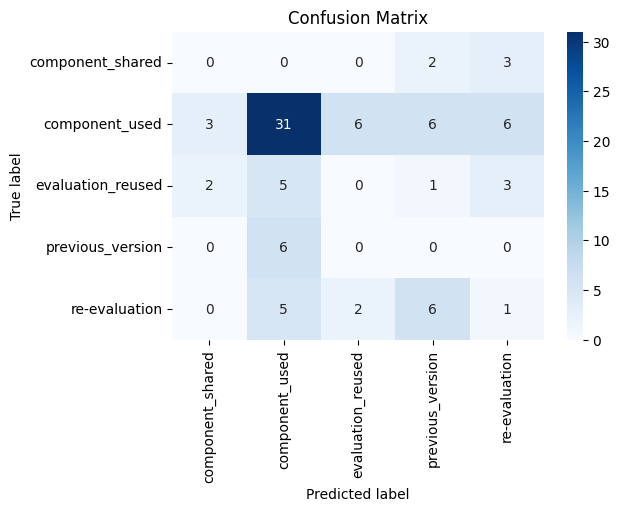

Accuracy: 0.3636, F1 score: 0.3818


In [54]:
conf_matrix = pd.crosstab(df_results["label"], df_results["gpt4omini_label"])
accuracy = (df_results["label"] == df_results["gpt4omini_label"]).mean()
f1 = f1_score(df_results["label"], df_results["gpt4omini_label"], average='weighted')
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(f"Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}")

In [55]:
df_results["label_simple"] = df_results["label"].apply(convert_label_type).apply(lambda x: x.value)
df_results["gpt4omini_label_simple"] = df_results["gpt4omini_label"].apply(convert_label_type).apply(lambda x: x.value)

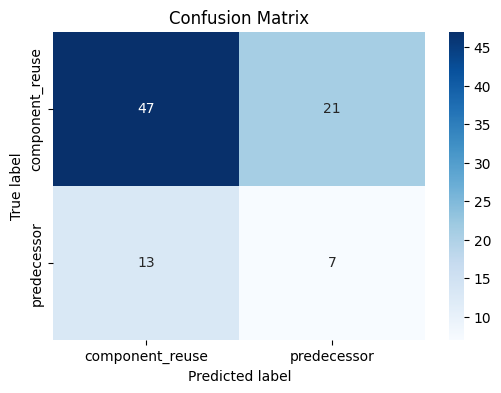

Accuracy: 0.6136, F1 score: 0.6338


In [ ]:
conf_matrix = pd.crosstab(df_results["label_simple"], df_results["gpt4omini_label_simple"])
accuracy = (df_results["label_simple"] == df_results["gpt4omini_label_simple"]).mean()
f1 = f1_score(df_results["label_simple"], df_results["gpt4omini_label_simple"], average='weighted')

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(f"Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}")